In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F

import torch
import os

import numpy as np


from torch.utils.data import DataLoader
from tqdm import tqdm

import cv2

import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from prettytable import PrettyTable

import optuna

C:\ProgramData\Anaconda3\envs\ocr\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
column_name = 'recognized_text_pytesseract'

In [3]:
def get_features(model, dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, texts, labels, path in tqdm(DataLoader(dataset, batch_size=100)):
            
            image_input = torch.tensor(np.stack(images)).cuda()
            text_tokens = clip.tokenize([desc[:77] for desc in texts]).cuda()
            
            image_features = model.encode_image(image_input).type(torch.float).cpu()
            text_features = model.encode_text(text_tokens).type(torch.float).cpu()

            features = torch.cat([image_features, text_features], dim=1)
            
            all_features.extend(features)
            all_labels.extend(labels)

    return all_features, all_labels


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    best_model_name = None
    loss_history = []
    train_history = []
    val_history = []
    top_val_accuracy = 0.52 
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x=x.type(torch.float).cpu()
            y = y.type(torch.float).cpu()
            model = model.cpu()
            prediction = model(x)    
            loss_value = loss(prediction, y.type(torch.long))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))

  
        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            model_name = f'classifier_{epoch}_{round(val_accuracy, 3)}.ckpt'
            best_model_name = model_name
            torch.save(model, open(model_name, 'wb'))
            print("saved", model_name)

    return loss_history, train_history, val_history, best_model_name
        
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0 
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
         
    return val_accuracy

In [4]:
prettyTable = PrettyTable(['Model name', 'Accuracy', 'ROC AUC'])

In [5]:
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize
from classes.dataset.FeaturesDataset import FeaturesDataset

In [6]:
import torch
import json
import os
from PIL import Image
import cv2
from cv2 import cv2


class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms, column_name):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.transforms = transforms
        self.column_name = column_name
        
    def __getitem__(self, index: int):
        #image = Image.open(os.path.join(self.data_dir, self.data[index]["img"]))   
        
        path = os.path.join(self.data_dir, self.data[index]["img"])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        text = self.data[index][self.column_name]
        label = self.data[index]["label"]

        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, text, label, path
    
    def __len__(self):
        return len(self.data)

In [7]:
CROP_SIZE=224

In [8]:
data_dir = r'E:\coding\HimariO\HatefulMemesChallenge\data\hateful_memes\\'

In [9]:
train_path = data_dir + 'train_ocr.jsonl'
dev_path = data_dir + 'dev_ocr.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [10]:
train_data

,id,img,label,text,recognized_text_pytesseract,recognized_text_easyocr
0,42953,img/42953.png,0,its their character not their color that matters,its their character hot their color that matt...,lits their characler' nlot tleir colar that ma...
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,don't he afraid to love r again everyone is ...,ilon't he afraidl 10 Ioue agail euerуо1e is ml...
2,13894,img/13894.png,0,putting bows on your pet,putting hows on your pet,IlltIinlg hows 0ll VOIIr [lel
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,iMlovereverything and Bare ios except for squ...,[lUшGuerything andl е1eПШЮШЫЕ eKcellt for sulu...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","""everyhotly loves chocolate chip cookies, eve...","""euervhotly loues chocolate chil cookies; euem..."
...,...,...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me,nobody wants to hang auschwitz me,nohotlv wants [0 hang auschwitz Ile
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...,vhien god grants you a child after 20 years of...,whcn goil grants UDII a chilil attct 20 uGars ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...,yay cn stivial meta: etucniy! tally positivity...,"'li65 IhI 5[I:X;] I:li;: #IIIKIl,l#! [ИH]# IIU..."
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...,having a bad tay? vou couli le a siamese twin ...,Inauing a bal ilav? VDL cuIIIIl Ile a SIamlles...


In [11]:
test_data

,id,img,label,text,recognized_text_pytesseract,recognized_text_easyocr
0,8291,img/08291.png,1,white people is this a shooting range,white people is this a shooting range,while meomle is Ihis a shooting range
1,46971,img/46971.png,1,bravery at its finest,bravery aLilsfinest,Wrauery aLilsfinBst
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white pri...,VOUX Oriler comeS 10 $37.50 antl vour white [r...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...,itis time.. to send these parasites hack to t...,it is Iillle.- ID seIlIl these mlarasites hack...
4,80243,img/80243.png,1,mississippi wind chime,mississippi wind chime,IIisSissilli windl chime
...,...,...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day,rm gonna he like phelps one day,iml gJullna he like phells 0Ile Ilay
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...,when you're so relaxed you can feel yourself ...,when vou're sO relaxell VOI can feel vourSelf ...
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...,look at this sandwich inaker club Hfound on w...,Iook at this samlwich Illaker clul fOIIIlII 0I...
498,9863,img/09863.png,0,diverse group of women,CIUEFSEWQKOUD Of women,(luemsegmmn ofmmGП


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### CLIP zero-shot learning

In [14]:
#https://github.com/openai/CLIP
model, preprocess = clip.load("ViT-L/14", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.946   0.04822 0.00594]]


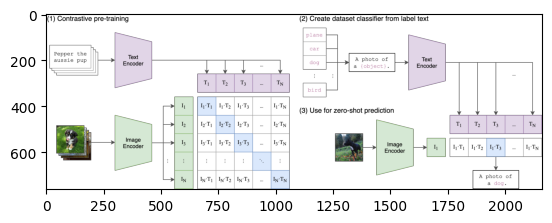

In [15]:
plt.imshow(Image.open("CLIP.png"))

In [16]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000002D1D57F5FC0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

#### Предобработка изображений

In [17]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [18]:
transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])


In [19]:
train_dataset = HatefulMemesDataset(train_path, transforms, column_name)
val_dataset = HatefulMemesDataset(dev_path, transforms, column_name)

  0%|                                                                                         | 0/1063 [00:00<?, ?it/s]


('its their character  hot their color that matters ', "don't he afraid to love  r again  everyone is not like Our eX ", 'putting hows on your pet  ', 'iMlovereverything and Bare ios  except for squirrels ihate squirrels ', '"everyhotly loves chocolate  chip cookies, even hitler ', 'go sports! tlo the thing! win the points! ', "fine  you're right. now can we fucking drop it? ", 'tattoos are had for your health  iknow 5 million people that had tattoos and they all died ')


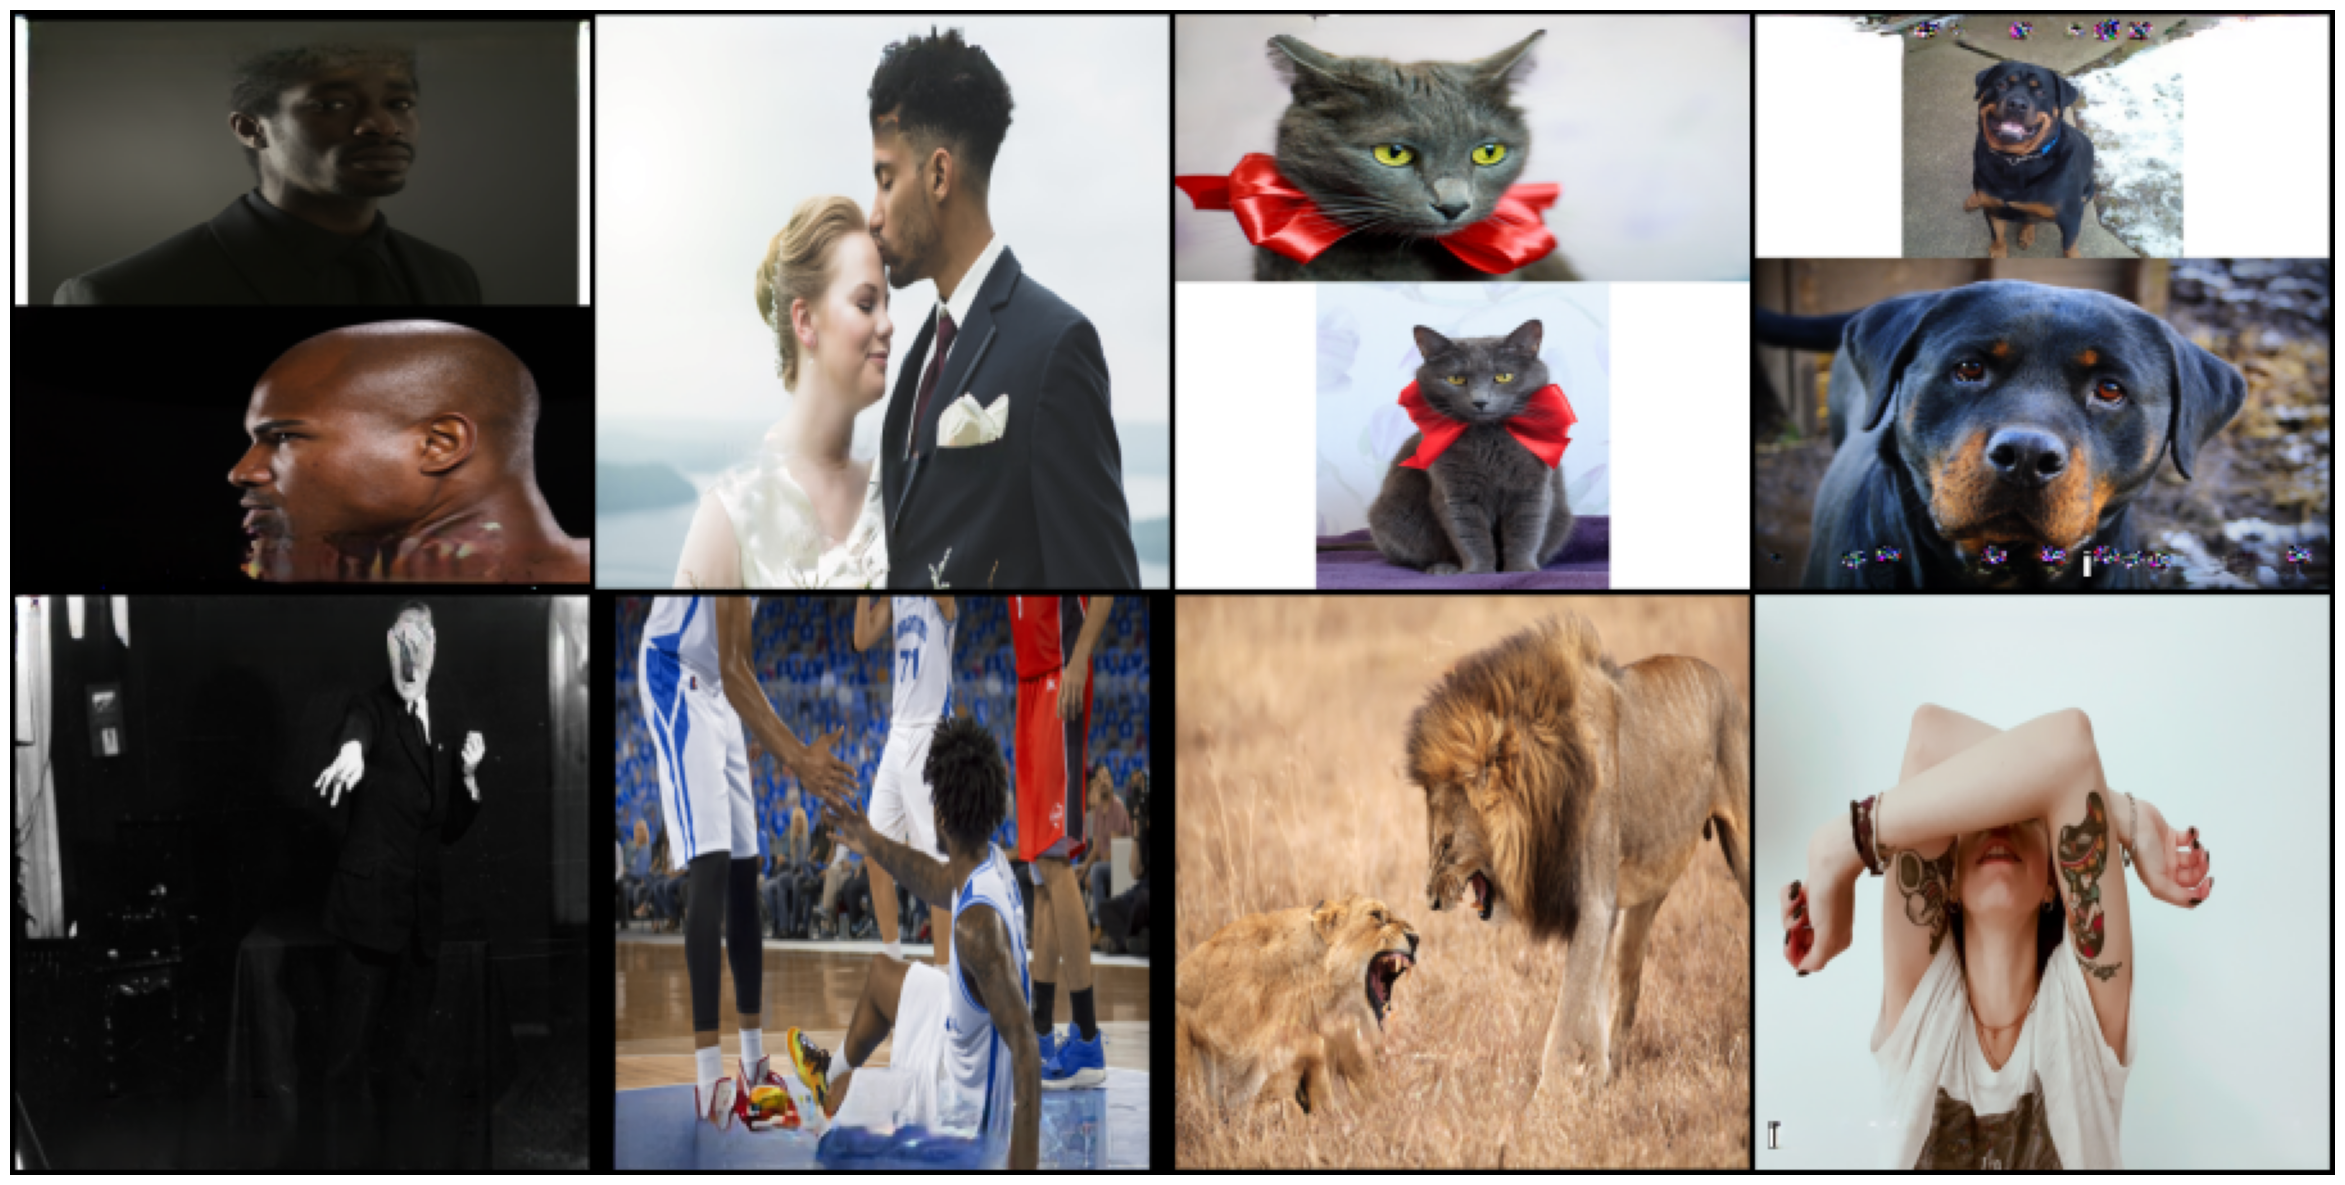

In [20]:
for images, texts, labels, path in tqdm(DataLoader(train_dataset, batch_size=8)):
    #print(images[0].shape, texts[0], labels[0] , labels.shape)
    break
    
grid = torchvision.utils.make_grid([(x * STD[:, None, None] + MEAN[:, None, None]) for x in images], nrow = 4)#
plt.figure(figsize=(30,20)); 
plt.axis(False)
plt.imshow(F.to_pil_image(grid));

print(texts)

#### Извлекаем признаки из текста и картинок

In [21]:
features_train, labels_train = get_features(model, train_dataset)
features_val, labels_val = get_features(model, val_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


In [22]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

#### Обучение нейросети

In [23]:
input_shape = features_train_dataset[0][0].shape[0]
num_classes = 2

In [24]:
input_shape

1536

In [25]:
torch.manual_seed(1024)

shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 200, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=1536, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.681302, Train accuracy: 0.622941, Val accuracy: 0.608000
saved classifier_0_0.608.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.581584, Train accuracy: 0.687765, Val accuracy: 0.506000
Epoch: 2 lr: 0.010000; Average loss: 0.518095, Train accuracy: 0.737176, Val accuracy: 0.576000
Epoch: 3 lr: 0.010000; Average loss: 0.500914, Train accuracy: 0.749765, Val accuracy: 0.524000
Epoch: 4 lr: 0.010000; Average loss: 0.474747, Train accuracy: 0.769647, Val accuracy: 0.

Epoch: 78 lr: 0.002097; Average loss: 0.027556, Train accuracy: 0.990353, Val accuracy: 0.620000
Epoch: 79 lr: 0.001678; Average loss: 0.021479, Train accuracy: 0.992706, Val accuracy: 0.616000
Epoch: 80 lr: 0.001678; Average loss: 0.026480, Train accuracy: 0.990706, Val accuracy: 0.624000
Epoch: 81 lr: 0.001678; Average loss: 0.022645, Train accuracy: 0.992824, Val accuracy: 0.630000
Epoch: 82 lr: 0.001678; Average loss: 0.022155, Train accuracy: 0.992471, Val accuracy: 0.630000
Epoch: 83 lr: 0.001678; Average loss: 0.020974, Train accuracy: 0.992118, Val accuracy: 0.622000
Epoch: 84 lr: 0.001678; Average loss: 0.020409, Train accuracy: 0.992471, Val accuracy: 0.622000
Epoch: 85 lr: 0.001678; Average loss: 0.022566, Train accuracy: 0.992471, Val accuracy: 0.616000
Epoch: 86 lr: 0.001678; Average loss: 0.019115, Train accuracy: 0.993059, Val accuracy: 0.620000
Epoch: 87 lr: 0.001678; Average loss: 0.022755, Train accuracy: 0.991882, Val accuracy: 0.626000
Epoch: 88 lr: 0.001678; Averag

Epoch: 162 lr: 0.000281; Average loss: 0.009476, Train accuracy: 0.996824, Val accuracy: 0.632000
Epoch: 163 lr: 0.000281; Average loss: 0.011025, Train accuracy: 0.995647, Val accuracy: 0.626000
Epoch: 164 lr: 0.000281; Average loss: 0.008592, Train accuracy: 0.996824, Val accuracy: 0.630000
Epoch: 165 lr: 0.000281; Average loss: 0.010778, Train accuracy: 0.996471, Val accuracy: 0.628000
Epoch: 166 lr: 0.000281; Average loss: 0.010503, Train accuracy: 0.996824, Val accuracy: 0.634000
Epoch: 167 lr: 0.000281; Average loss: 0.009782, Train accuracy: 0.997059, Val accuracy: 0.636000
Epoch: 168 lr: 0.000281; Average loss: 0.013425, Train accuracy: 0.995412, Val accuracy: 0.628000
Epoch: 169 lr: 0.000225; Average loss: 0.008739, Train accuracy: 0.997059, Val accuracy: 0.632000
Epoch: 170 lr: 0.000225; Average loss: 0.008520, Train accuracy: 0.997647, Val accuracy: 0.630000
Epoch: 171 lr: 0.000225; Average loss: 0.009701, Train accuracy: 0.996588, Val accuracy: 0.630000
Epoch: 172 lr: 0.000

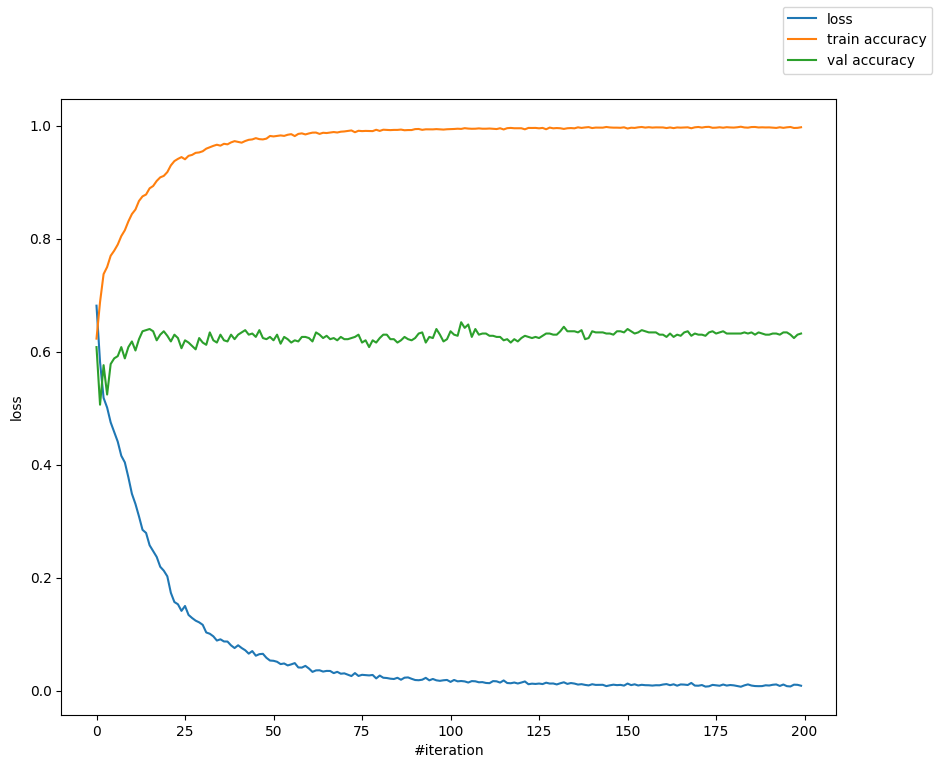

In [26]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [27]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

best model: classifier_103_0.652.ckpt
Sequential(
  (0): Linear(in_features=1536, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


Accuracy: 0.652
ROC AUC: 0.6975199999999999


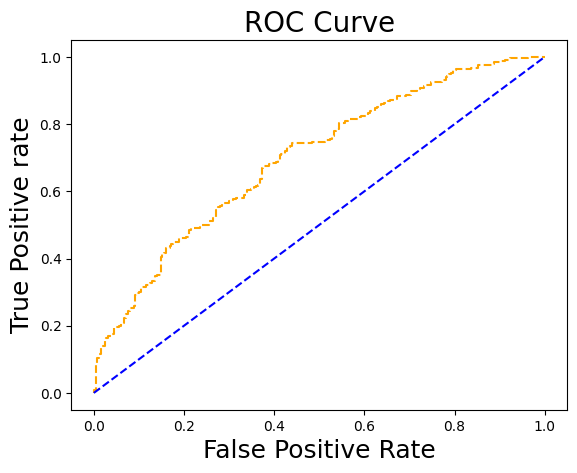

In [28]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
prettyTable.add_row(['Neural Network', acc_score, auc_score])

fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())

print('Accuracy: ', acc_score, '\n', 'ROC AUC: ', auc_score, sep='')

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

In [29]:
print(prettyTable)

+----------------+----------+--------------------+
|   Model name   | Accuracy |      ROC AUC       |
+----------------+----------+--------------------+
| Neural Network |  0.652   | 0.6975199999999999 |
+----------------+----------+--------------------+
